# Import Libraries


In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    auc,
    RocCurveDisplay,
    roc_curve,
)
from sklearn.model_selection import StratifiedKFold
import pandas as pd
from config import config, models
from utils import fine_tune, flatten_datasets, augment_images

# Prepare Training and Testing Data


In [2]:
data_dir = "dataset/2-cropped-v3"
class_names = os.listdir(data_dir)

train_set, test_set = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    seed=config["seed_value"],
    image_size=config["img_shape"],
    batch_size=config["batch_size"],
    label_mode="categorical",
    subset="both",
)

train_images, train_labels = flatten_datasets(train_set)
test_images, test_labels = flatten_datasets(test_set)

Found 447 files belonging to 2 classes.
Using 358 files for training.
Using 89 files for validation.


# Defining the Base Model

This project will be using EfficientNetV2-B0 and MobileNetV3-Small. We can easily get this from the TensorFlow API. Let's set a `flag` variable so we can easily set which model we want to test with.


In [3]:
flag = 1

base_model = models[flag]["base_model"]
model_name = models[flag]["model_name"]
num_layers_to_freeze = models[flag]["num_layers_to_freeze"]

# Predicting with the Model


In [4]:
model = fine_tune(base_model, config, num_layers_to_freeze)

In [5]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=config["seed_value"])

train_tprs = []
train_aucs = []

valid_tprs = []
valid_aucs = []

test_tprs = []
test_aucs = []

mean_fpr = np.linspace(0, 1, 100)

# Loop over the dataset to create separate folds
for i, (train_idx, valid_idx) in enumerate(
    cv.split(train_images, np.argmax(train_labels, axis=1))
):
    print(f"\nFold {i + 1}")
    # Get the training and validation data
    X_train, X_valid = train_images[train_idx, :], train_images[valid_idx, :]
    y_train, y_valid = train_labels[train_idx], train_labels[valid_idx]

    # Create a new model instance and load model weights
    checkpoints_path = f"checkpoints/{model_name}/fold_{i+1}"
    latest_checkpoint = tf.train.latest_checkpoint(checkpoints_path)
    model.load_weights(latest_checkpoint)

    # Augment ONLY training data
    X_train, y_train = augment_images(X_train, y_train, 5)

    # Predict training data
    y_train_preds = model.predict(X_train)[:, 1]
    fpr, tpr, _ = roc_curve(y_train.argmax(axis=1), y_train_preds, pos_label=1)
    roc_auc = auc(fpr, tpr)

    train_tprs.append(np.interp(mean_fpr, fpr, tpr))
    train_aucs.append(roc_auc)

    # Predict validation data
    y_valid_preds = model.predict(X_valid)[:, 1]
    fpr, tpr, _ = roc_curve(y_valid.argmax(axis=1), y_valid_preds, pos_label=1)
    roc_auc = auc(fpr, tpr)

    valid_tprs.append(np.interp(mean_fpr, fpr, tpr))
    valid_aucs.append(roc_auc)

    # Predict testing data
    test_preds = model.predict(test_images)[:, 1]
    test_fpr, test_tpr, _ = roc_curve(
        test_labels.argmax(axis=1), test_preds, pos_label=1
    )
    test_auc = auc(test_fpr, test_tpr)

    test_tprs.append(np.interp(mean_fpr, test_fpr, test_tpr))
    test_aucs.append(test_auc)


Fold 1
3/3 [==============================] - 0s 57ms/step

Fold 2
3/3 [==============================] - 0s 12ms/step

Fold 3
3/3 [==============================] - 0s 12ms/step

Fold 4
3/3 [==============================] - 0s 13ms/step

Fold 5
3/3 [==============================] - 0s 12ms/step


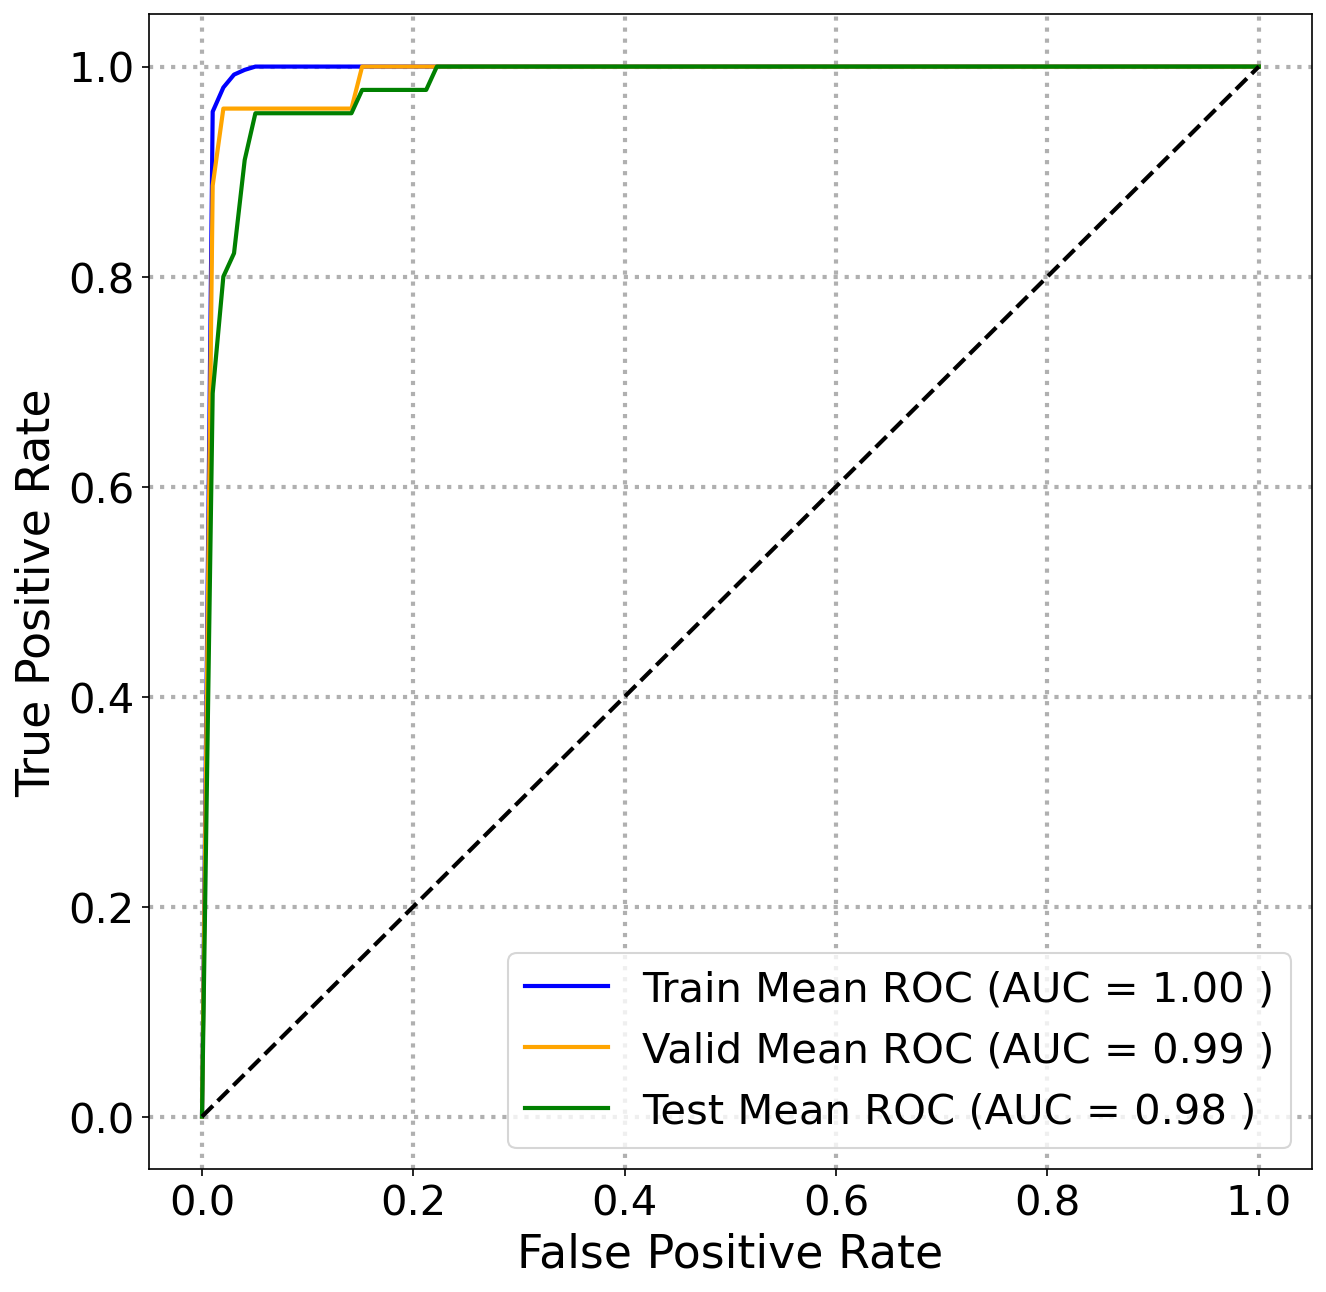

In [6]:
plt.rcParams["font.size"] = 20
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["axes.titlepad"] = 15
fig, ax = plt.subplots(figsize=(10, 10), dpi=150)

# train_tprs[np.isnan(train_tprs)] = 0

train_mean_roc_auc = np.mean(train_aucs)
train_mean_tpr = np.mean(train_tprs, axis=0)
train_mean_tpr[0] = 0.0
plt.plot(
    mean_fpr,
    train_mean_tpr,
    color="blue",
    label=r"Train Mean ROC (AUC = %0.2f )" % (train_mean_roc_auc),
    lw=2,
    alpha=1,
)

valid_mean_roc_auc = np.mean(valid_aucs)
valid_mean_tpr = np.mean(valid_tprs, axis=0)
valid_mean_tpr[0] = 0.0
plt.plot(
    mean_fpr,
    valid_mean_tpr,
    color="orange",
    label=r"Valid Mean ROC (AUC = %0.2f )" % (valid_mean_roc_auc),
    lw=2,
    alpha=1,
)

test_mean_roc_auc = np.mean(test_aucs)
test_mean_tpr = np.mean(test_tprs, axis=0)
test_mean_tpr[0] = 0.0
plt.plot(
    mean_fpr,
    test_mean_tpr,
    color="green",
    label=r"Test Mean ROC (AUC = %0.2f )" % (test_mean_roc_auc),
    lw=2,
    alpha=1,
)
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="black")
plt.xlabel("False Positive Rate", fontsize=22)
plt.ylabel("True Positive Rate", fontsize=22)
plt.legend(loc="lower right")
plt.grid(linestyle="dotted", lw=2)

plt.show()

In [7]:
# Read all folds
fold_1 = pd.read_csv(f"results/{model_name}/fold_1.csv")
fold_2 = pd.read_csv(f"results/{model_name}/fold_2.csv")
fold_3 = pd.read_csv(f"results/{model_name}/fold_3.csv")
fold_4 = pd.read_csv(f"results/{model_name}/fold_4.csv")
fold_5 = pd.read_csv(f"results/{model_name}/fold_5.csv")

In [29]:
def get_average_metric(model_name, metric):
    fold_1 = pd.read_csv(f"results/{model_name}/fold_1.csv", na_values=0)
    fold_2 = pd.read_csv(f"results/{model_name}/fold_2.csv", na_values=0)
    fold_3 = pd.read_csv(f"results/{model_name}/fold_3.csv", na_values=0)
    fold_4 = pd.read_csv(f"results/{model_name}/fold_4.csv", na_values=0)
    fold_5 = pd.read_csv(f"results/{model_name}/fold_5.csv", na_values=0)

    # replace all nan value with 0
    fold_1 = fold_1.fillna(0, axis=0)

    # get the average curve
    average_metric = (
        fold_1[metric]
        + fold_2[metric]
        + fold_3[metric]
        + fold_4[metric]
        + fold_5[metric]
    ) / 5

    return average_metric

In [30]:
mobilenetv3small_loss = get_average_metric("Mobilenetv3small", "loss")
mobilenetv3small_val_loss = get_average_metric("Mobilenetv3small", "val_loss")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


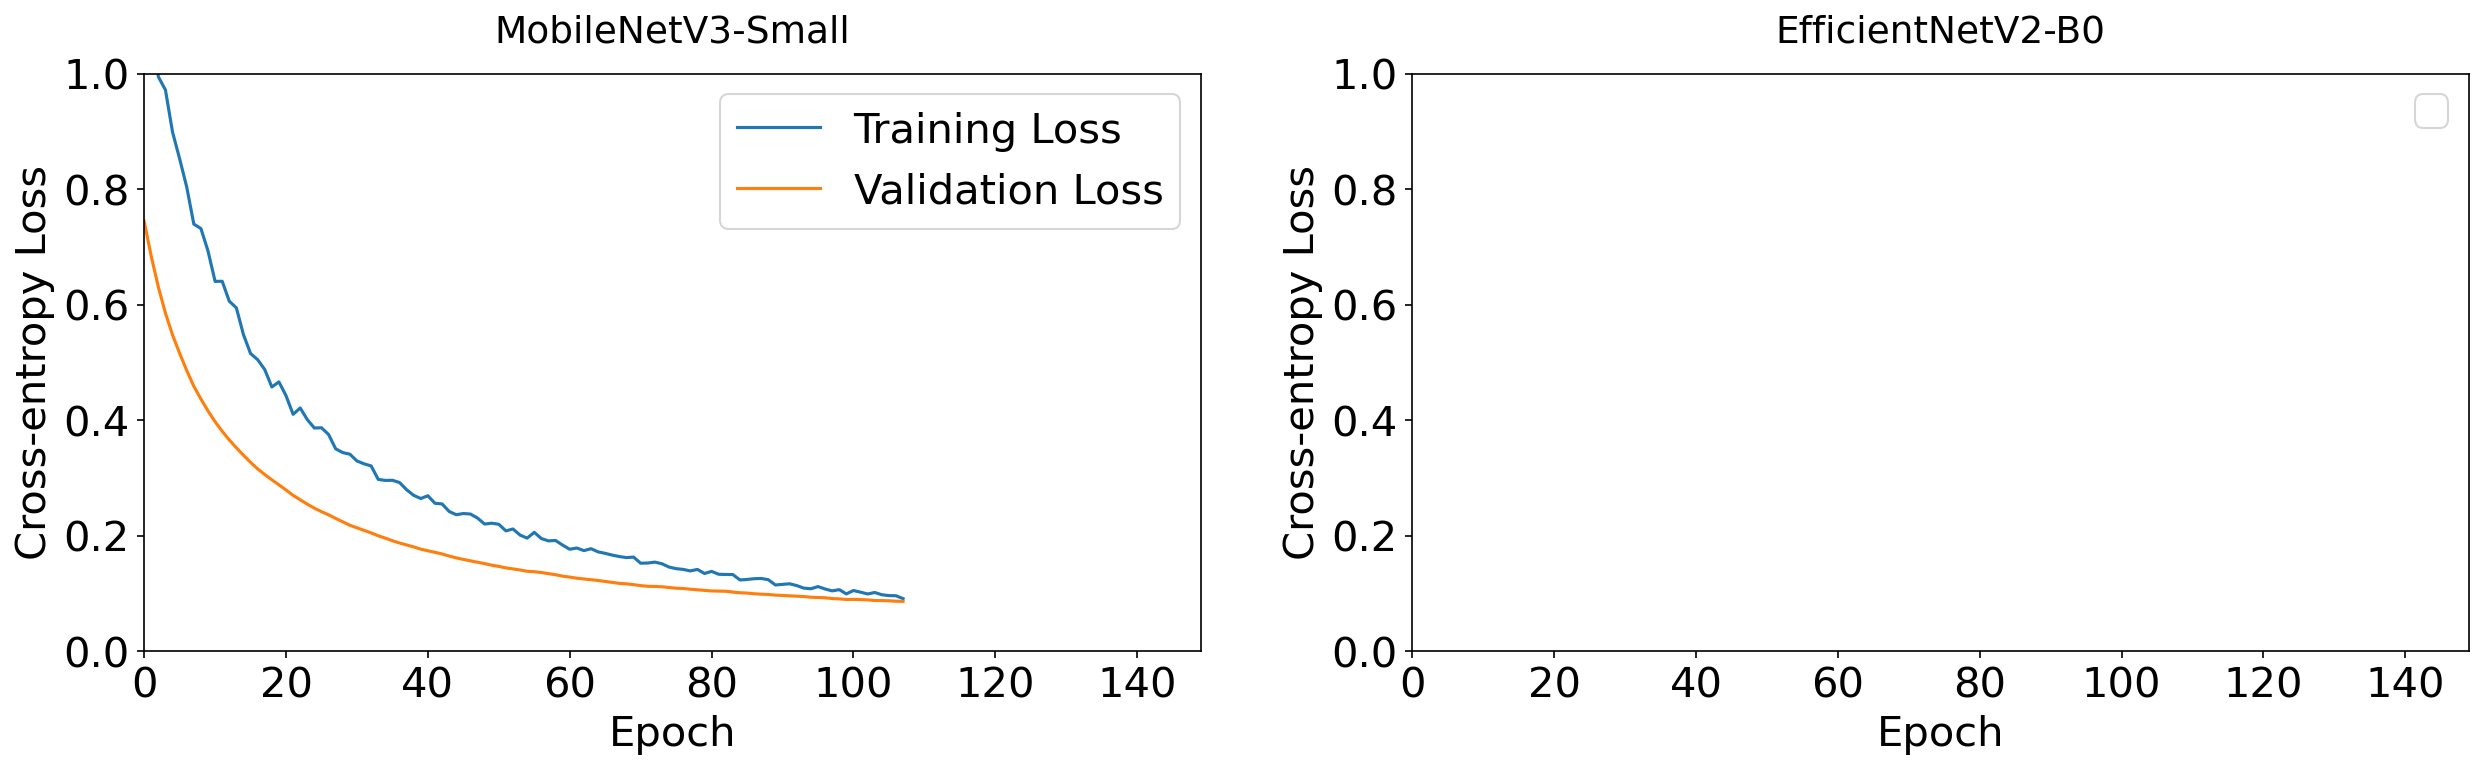

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=150, figsize=(20, 5))

ax1.plot(
    mobilenetv3small_loss,
    label="Training Loss",
)
ax1.plot(
    mobilenetv3small_val_loss,
    label="Validation Loss",
)

# ax2.plot(
#     efficientnet_fold["loss"],
#     label="Training Loss",
# )
# ax2.plot(
#     efficientnet_fold["val_loss"],
#     label="Validation Loss",
# )

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Cross-entropy Loss")
ax1.set_title("MobileNetV3-Small")
ax1.set_xlim(0, 149)
ax1.set_ylim(0, 1)
ax1.legend()

ax2.set_xlabel("Epoch")
ax2.set_ylabel("Cross-entropy Loss")
ax2.set_title("EfficientNetV2-B0")
ax2.set_xlim(0, 149)
ax2.set_ylim(0, 1)
ax2.legend()


plt.show()

In [10]:
fold_1["fnr"] = fold_1.apply(
    lambda row: row["false_negatives"]
    / (row["true_positives"] + row["false_negatives"]),
    axis=1,
)
fold_2["fnr"] = fold_2.apply(
    lambda row: row["false_negatives"]
    / (row["true_positives"] + row["false_negatives"]),
    axis=1,
)
fold_3["fnr"] = fold_3.apply(
    lambda row: row["false_negatives"]
    / (row["true_positives"] + row["false_negatives"]),
    axis=1,
)
fold_4["fnr"] = fold_4.apply(
    lambda row: row["false_negatives"]
    / (row["true_positives"] + row["false_negatives"]),
    axis=1,
)
fold_5["fnr"] = fold_5.apply(
    lambda row: row["false_negatives"]
    / (row["true_positives"] + row["false_negatives"]),
    axis=1,
)

fold_1["val_fnr"] = fold_1.apply(
    lambda row: row["false_negatives"]
    / (row["true_positives"] + row["false_negatives"]),
    axis=1,
)

fold_2["val_fnr"] = fold_2.apply(
    lambda row: row["false_negatives"]
    / (row["true_positives"] + row["false_negatives"]),
    axis=1,
)

fold_3["val_fnr"] = fold_3.apply(
    lambda row: row["false_negatives"]
    / (row["true_positives"] + row["false_negatives"]),
    axis=1,
)

fold_4["val_fnr"] = fold_4.apply(
    lambda row: row["false_negatives"]
    / (row["true_positives"] + row["false_negatives"]),
    axis=1,
)

fold_5["val_fnr"] = fold_5.apply(
    lambda row: row["false_negatives"]
    / (row["true_positives"] + row["false_negatives"]),
    axis=1,
)

In [11]:
f1_score = (
    np.max(fold_1["f1_score"])
    + np.max(fold_2["f1_score"])
    + np.max(fold_3["f1_score"])
    + np.max(fold_4["f1_score"])
    + np.max(fold_5["f1_score"])
) / 5

std_f1_score = np.std(
    [
        np.max(fold_1["f1_score"]),
        np.max(fold_2["f1_score"]),
        np.max(fold_3["f1_score"]),
        np.max(fold_4["f1_score"]),
        np.max(fold_5["f1_score"]),
    ]
)

auc = (
    train_aucs[0] + train_aucs[1] + train_aucs[2] + train_aucs[3] + train_aucs[4]
) / 5

std_auc = np.std(
    [
        train_aucs[0],
        train_aucs[1],
        train_aucs[2],
        train_aucs[3],
        train_aucs[4],
    ]
)

fnr = (
    np.min(fold_1["fnr"])
    + np.min(fold_2["fnr"])
    + np.min(fold_3["fnr"])
    + np.min(fold_4["fnr"])
    + np.min(fold_5["fnr"])
) / 5

std_fnr = np.std(
    [
        np.min(fold_1["fnr"]),
        np.min(fold_2["fnr"]),
        np.min(fold_3["fnr"]),
        np.min(fold_4["fnr"]),
        np.min(fold_5["fnr"]),
    ]
)

val_f1_score = (
    np.max(fold_1["val_f1_score"])
    + np.max(fold_2["val_f1_score"])
    + np.max(fold_3["val_f1_score"])
    + np.max(fold_4["val_f1_score"])
    + np.max(fold_5["val_f1_score"])
) / 5

std_val_f1_score = np.std(
    [
        np.max(fold_1["val_f1_score"]),
        np.max(fold_2["val_f1_score"]),
        np.max(fold_3["val_f1_score"]),
        np.max(fold_4["val_f1_score"]),
        np.max(fold_5["val_f1_score"]),
    ]
)

val_auc = (
    valid_aucs[0] + valid_aucs[1] + valid_aucs[2] + valid_aucs[3] + valid_aucs[4]
) / 5

std_val_auc = np.std(
    [
        valid_aucs[0],
        valid_aucs[1],
        valid_aucs[2],
        valid_aucs[3],
        valid_aucs[4],
    ]
)

val_fnr = (
    np.min(fold_1["val_fnr"])
    + np.min(fold_2["val_fnr"])
    + np.min(fold_3["val_fnr"])
    + np.min(fold_4["val_fnr"])
    + np.min(fold_5["val_fnr"])
) / 5

std_val_fnr = np.std(
    [
        np.min(fold_1["val_fnr"])
        + np.min(fold_2["val_fnr"])
        + np.min(fold_3["val_fnr"])
        + np.min(fold_4["val_fnr"])
        + np.min(fold_5["val_fnr"])
    ]
)

test_results = model.evaluate(test_set)
test_f1_score = test_results[1]
test_auc = test_roc_auc
test_fnr = test_results[2] / (test_results[2] + test_results[3])

2/2 [==============================] - 1s 33ms/step - loss: 0.1761 - precision: 0.9213 - recall: 0.9213 - f1_score: 0.8980 - false_negatives: 7.0000 - true_positives: 82.0000 - false_positives: 7.0000 - true_negatives: 82.0000


NameError: name 'test_roc_auc' is not defined

In [ ]:
df = pd.DataFrame(
    {
        "f1_score": [f1_score],
        "std_f1_score": [std_f1_score],
        "auc": [auc],
        "std_auc": [std_auc],
        "fnr": [fnr],
        "std_fnr": [std_fnr],
        "val_f1_score": [val_f1_score],
        "std_val_f1_score": [std_val_f1_score],
        "val_auc": [val_auc],
        "std_val_auc": [std_val_auc],
        "val_fnr": [val_fnr],
        "std_val_fnr": [std_val_fnr],
        "test_f1_score": [test_f1_score],
        "test_auc": [test_auc],
        "test_fnr": [test_fnr],
    }
)